In [1]:
import os
os.chdir("/oak/stanford/groups/akundaje/kobbad/UCE")
from model import *
import scanpy as sc
from tqdm.auto import tqdm
from torch import nn, Tensor
from evaluate import get_ESM2_embeddings
from utils import get_ESM2_embeddings_x
import argparse
from accelerate import Accelerator
from evaluate import AnndataProcessor
from eval_data import MultiDatasetSentences, MultiDatasetSentenceCollator
import pickle
from torch.utils.data import DataLoader
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TODO:

1. We generate a mapping from every gene to every protein embedding id. (dataset.dataset_to_protein_embeddings[dataset.datasets[0]])

2. We create a mapping from TFs to target genes. note: we need to know if they are repressors or activators. We probably make two mappings for each category.

3. We modify the cell sampler to generate masks for any samples that have TFs that are interesting in them?

4. We then generate a cell embedding and then generate logits for the target genes?

In [2]:
tf_df = pd.read_csv("./data/gene_attribute_matrix.txt", sep="\t", index_col=0)

In [3]:
# filter out columns 1 and 2
tf_df = tf_df.iloc[2:, 2:]

tf_df.head()

,ARID3A,ATF1,ATF2,ATF3,BACH1,BATF,BCL11A,BCL3,BCLAF1,BDP1,...,ZC3H11A,ZEB1,ZKSCAN1,ZMIZ1,ZNF143,ZNF217,ZNF263,ZNF274,ZNF384,ZZZ3
#,,,,,,,,,,,,,,,,,,,,,
A1BG,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A1BG-AS1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A1CF,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A2M,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A2ML1,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000


In [4]:
df = tf_df.round(decimals=0)

In [5]:
df = df.apply(pd.to_numeric, errors='coerce')

In [6]:
df.head()

,ARID3A,ATF1,ATF2,ATF3,BACH1,BATF,BCL11A,BCL3,BCLAF1,BDP1,...,ZC3H11A,ZEB1,ZKSCAN1,ZMIZ1,ZNF143,ZNF217,ZNF263,ZNF274,ZNF384,ZZZ3
#,,,,,,,,,,,,,,,,,,,,,
A1BG,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BG-AS1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2ML1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [7]:
value_counts = pd.Series(tf_df.values.flatten()).value_counts()

print(value_counts)


0.0         2029601
1.0         1359624
0.000000     445255
1.000000     295759
Name: count, dtype: int64


In [8]:
df.sum(axis=0).sort_values(ascending=False)[0:50]

CTCF       21537.0
POLR2A     21475.0
EZH2       20368.0
H2AFZ      20002.0
EP300      19042.0
MYC        18495.0
MAX        18165.0
HDAC2      17718.0
RBBP5      17675.0
CHD1       17509.0
JUND       17146.0
SIN3A      16915.0
MAZ        16639.0
MXI1       16591.0
RCOR1      16504.0
TBP        16476.0
SAP30      16336.0
CEBPB      16276.0
ZNF143     16226.0
RAD21      16207.0
CHD2       16175.0
YY1        15774.0
BHLHE40    15759.0
REST       15543.0
MAFK       15429.0
TCF12      15392.0
PHF8       15246.0
SMC3       15214.0
TAF1       15175.0
KDM4A      14741.0
GTF2F1     14378.0
E2F6       14265.0
USF2       14263.0
ELF1       14244.0
RFX5       14210.0
KDM5B      14175.0
TEAD4      13984.0
STAT3      13918.0
SP1        13904.0
HDAC1      13853.0
E2F4       13729.0
HCFC1      13621.0
ZNF384     13485.0
UBTF       13355.0
KDM5A      13340.0
TBL1XR1    13265.0
CREB1      13252.0
ZBTB7A     13188.0
FOS        13087.0
GABPA      13049.0
dtype: float64

In [9]:
adata = sc.read("10k_pbmcs_proc_uce_adata.h5ad")

In [28]:
spi1_gene_index = adata.var['gene_symbols'].to_list().index("EZH2")

In [24]:
genes_turned_on_by_spi1 = df.index[df.loc[:, "CTCF"] == 1].to_list()

In [31]:
adata.X.shape

(11990, 10809)

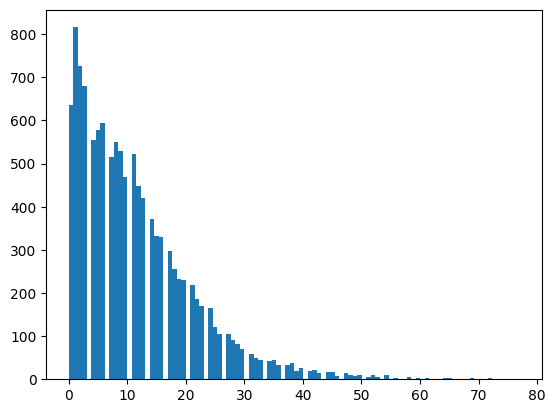

In [34]:
fos_gene_index = adata.var['gene_symbols'].to_list().index("FOS")
plt.hist(adata.X[:, fos_gene_index].toarray(), bins=100);

In [38]:
fos_annotated_targets = df.index[df.loc[:,"FOS"] == 1].to_list()

In [40]:
indices_of_fos_annotated_targets = []

for gene in fos_annotated_targets:
    if gene in adata.var['gene_symbols']:
        indices_of_fos_annotated_targets.append(adata.var['gene_symbols'].to_list().index(gene))

In [43]:
from tqdm import tqdm
from scipy.stats import pearsonr


corrs = []

for idx in tqdm(indices_of_fos_annotated_targets):
    corrs.append(pearsonr(adata.X[:, fos_gene_index].toarray().flatten(), adata.X[:, idx].toarray().flatten())[0])

100%|██████████| 7726/7726 [03:54<00:00, 32.88it/s]


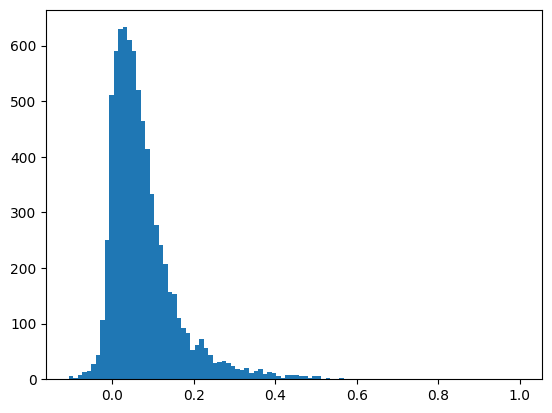

In [44]:
plt.hist(corrs, bins=100);

In [49]:
# dict of indices 
gene_names_in_order = [adata.var['gene_symbols'][idx] for idx in indices_of_fos_annotated_targets]

corrs_dict = dict(zip(gene_names_in_order, corrs))

# sort corrs_dict by values
corrs_dict = dict(sorted(corrs_dict.items(), key=lambda item: item[1], reverse=True))

In [50]:
corrs_dict

{'FOS': 1.0,
 'DUSP1': 0.6543056840552535,
 'ZFP36': 0.6065653226919547,
 'FOSB': 0.5671313015781304,
 'RPS24': 0.5592406639345722,
 'SRGN': 0.5582780490543483,
 'S100A6': 0.5567827286630938,
 'KLF4': 0.543543797715243,
 'FTH1': 0.5346695356986086,
 'S100A11': 0.5303297113143493,
 'S100A4': 0.5272616731672071,
 'OAZ1': 0.5169974428703658,
 'MCL1': 0.510512690117906,
 'AP1S2': 0.5079374787823068,
 'TMSB4X': 0.5066327268760048,
 'RGS2': 0.5063421879380995,
 'TSPO': 0.5022790837961726,
 'LGALS1': 0.501668557372712,
 'GPX1': 0.49895194937726883,
 'FTL': 0.4962267602234638,
 'GSTP1': 0.49607047519111164,
 'CSTA': 0.4936875679356062,
 'TYMP': 0.48690666563414436,
 'RAC1': 0.4821696953095906,
 'SAT1': 0.4795457663738124,
 'CTSS': 0.4789527466694735,
 'GRN': 0.4771219111278726,
 'ANXA1': 0.4750057027728829,
 'NFKBIA': 0.4731557134979358,
 'RNF130': 0.4721915067536988,
 'FKBP1A': 0.46802028123218997,
 'COTL1': 0.46701780028121553,
 'VIM': 0.4650595101668155,
 'FCER1G': 0.46409968606792074,
 'TK

In [55]:
# save corrs_dict to file

with open("./notebooks/2024/AUG/fos_corrs_dict.pkl", "wb") as f:
    pickle.dump(corrs_dict, f)

In [53]:
adata.var['gene_symbols'].to_list().index("DUSP1"), adata.var['gene_symbols'].to_list().index("FOS")

(3214, 7506)

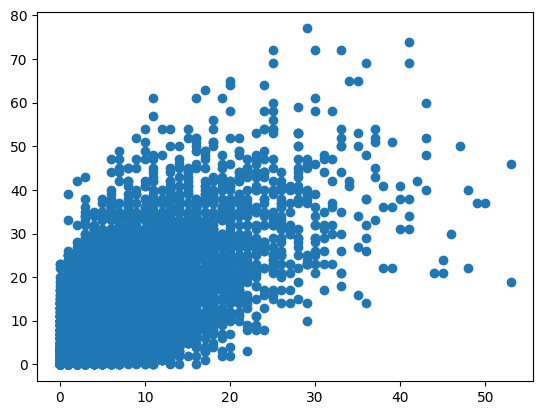

In [54]:
plt.scatter(adata.X[:, adata.var['gene_symbols'].to_list().index("DUSP1")].toarray(), adata.X[:, adata.var['gene_symbols'].to_list().index("FOS")].toarray());

In [48]:
adata.var['gene_symbols'][indices_of_fos_annotated_targets[np.argmax(corrs)]]

'FOS'

In [29]:
adata.var[adata.var["gene_symbols"]=="BCL3"]

,gene_symbols,n_counts-0,n_counts-1,n_counts,highly_variable,highly_variable_rank,means,variances,variances_norm,n_cells
BCL3,BCL3,282.0,121.0,389.0,True,4521.0,0.032444,0.033896,0.972795,374


In [30]:
df.index

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2ML1', 'A2MP1', 'A3GALT2',
       'A4GALT', 'A4GNT', 'AA06',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', name='#', length=22819)

In [31]:
genes_in_dataset = adata.var["gene_symbols"].to_list()

tfs_in_annot = df.columns.to_list()

genes_in_annot = df.index.to_list()



Next, I want to find all the TFs that are in anndata object and find which of their gene targets are also in there

In [32]:
tfs_in_dataset = [tf for tf in tfs_in_annot if tf in genes_in_dataset]

len(tfs_in_dataset), len(tfs_in_annot)

(147, 181)

In [47]:
tfs_in_dataset

['ARID3A',
 'ATF2',
 'ATF3',
 'BACH1',
 'BATF',
 'BCL11A',
 'BCL3',
 'BDP1',
 'BHLHE40',
 'BRCA1',
 'BRF1',
 'BRF2',
 'CBX2',
 'CBX8',
 'CCNT2',
 'CEBPB',
 'CEBPD',
 'CEBPZ',
 'CHD1',
 'CHD4',
 'CHD7',
 'CREB1',
 'CREBBP',
 'CTBP2',
 'CTCF',
 'CUX1',
 'E2F1',
 'E2F4',
 'E2F6',
 'EBF1',
 'EGR1',
 'ELK1',
 'ELK4',
 'EP300',
 'ESR1',
 'ESRRA',
 'ETS1',
 'EZH2',
 'FLI1',
 'FOS',
 'FOSL2',
 'FOXM1',
 'GABPA',
 'GATA1',
 'GATA2',
 'GATA3',
 'GTF2B',
 'GTF2F1',
 'GTF3C2',
 'HCFC1',
 'HDAC2',
 'HDAC6',
 'IRF1',
 'IRF4',
 'JUN',
 'JUND',
 'KAT2A',
 'KAT2B',
 'KDM1A',
 'KDM4A',
 'KDM5A',
 'KDM5B',
 'MAFF',
 'MAFK',
 'MAX',
 'MAZ',
 'MBD4',
 'MEF2A',
 'MEF2C',
 'MTA3',
 'MXI1',
 'MYB',
 'MYBL2',
 'MYC',
 'NFATC1',
 'NFE2',
 'NFIC',
 'NFYA',
 'NFYB',
 'NR2C2',
 'NR3C1',
 'NRF1',
 'PAX5',
 'PBX3',
 'PHF8',
 'PML',
 'POLR2A',
 'POLR3A',
 'POLR3G',
 'POU2F2',
 'POU5F1',
 'PRDM1',
 'RAD21',
 'RBBP5',
 'RCOR1',
 'REST',
 'RFX5',
 'RNF2',
 'RUNX3',
 'RXRA',
 'SAP30',
 'SETDB1',
 'SIN3A',
 'SIRT6',
 'SIX

In [60]:
adata.X[:, adata.var['gene_symbols'] == "SPI1"].toarray().sum()

11031.0

In [33]:
overlapping_genes = [gene for gene in genes_in_annot if gene in genes_in_dataset]

len(overlapping_genes), len(genes_in_dataset)

(10484, 10809)

In [34]:
# subset the dataframe to only include genes in the dataset and tfs
df_subset = df.loc[overlapping_genes, tfs_in_dataset]

df_subset.shape, df.shape

((10484, 147), (22819, 181))

In [35]:
df_subset.sum(axis=0).sort_values(ascending=False)

POLR2A     10381.0
CTCF       10374.0
EP300      10086.0
EZH2        9996.0
MAX         9958.0
            ...   
SMARCA4       30.0
BRF1          26.0
POLR3G        15.0
BRF2           7.0
XRCC4          3.0
Length: 147, dtype: float64

In [37]:
adata.X.shape

(11990, 10809)

I probably should curate some TFs for this dataset since it seems like some of the TFs above aren't great. 

Also, I should probably plot the expression of some genes to make sure I am using TFs and target genes that are expressed. 

In [38]:
tfs_expression = adata.X[:, adata.var["gene_symbols"].isin(tfs_in_dataset)]

tfs_expression.shape

(11990, 147)

In [39]:
# Boolean mask for TFs in the dataset
tfs_mask = adata.var["gene_symbols"].isin(tfs_in_dataset)

# Extract the corresponding gene IDs
tfs_gene_ids = adata.var.index[tfs_mask]

In [40]:
tfs_expression = tfs_expression.toarray()

tfs_expression.shape

(11990, 147)

In [41]:
tfs_expression

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

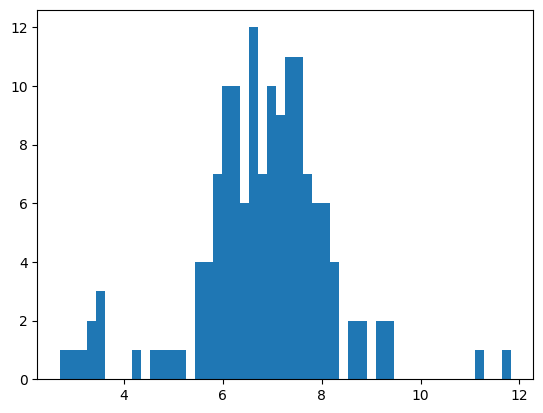

In [29]:
plt.hist(np.log1p(tfs_expression.sum(axis=0)), bins=50);

In [42]:
sorted_indices = np.argsort(tfs_expression.sum(axis=0))[::-1]

In [43]:
np.array(tfs_gene_ids)[sorted_indices[:50]]

array(['FOS', 'JUN', 'JUND', 'SPI1', 'CEBPB', 'IRF1', 'MEF2C', 'ETS1',
       'POU2F2', 'CEBPD', 'MAX', 'RAD21', 'STAT1', 'NR3C1', 'CHD1',
       'FLI1', 'SMARCB1', 'USF2', 'SMC3', 'MYC', 'REST', 'MBD4', 'ZBTB7A',
       'KDM5A', 'HDAC2', 'MAZ', 'GTF2F1', 'SMARCC1', 'BDP1', 'UBTF',
       'CEBPZ', 'CHD4', 'RUNX3', 'GATA3', 'ZC3H11A', 'CUX1', 'SUZ12',
       'BCL11A', 'MEF2A', 'CTCF', 'TBL1XR1', 'CREB1', 'ZNF274', 'E2F4',
       'POLR2A', 'SMARCC2', 'STAT2', 'STAT5A', 'GTF2B', 'ELK4'],
      dtype=object)

In [59]:
df.loc[df["STAT2"] == 1, "STAT2"].index.to_list().index("ISG20")

105

ok, so I have a TF "STAT2" and a bunch of targets like "ISG15" that are known. We knock out both of these by setting their counts to 0. We have a knockout anndata and a regular anndata. We generate several cell embeddings in different scenarios:

1. We knockout both and predict ISG15 expression. 
2. We keep both in and predict ISG15 expression. 
3. We keep STAT5 and knockout ISG15 and make sure ISG15 is still predicted to be expressed. 

In [12]:
parser = argparse.ArgumentParser(
    description='Embed a single anndata using UCE.')

# Anndata Processing Arguments
parser.add_argument('--adata_path', type=str,
                    default=None,
                    help='Full path to the anndata you want to embed.')
parser.add_argument('--dir', type=str,
                    default="./",
                    help='Working folder where all files will be saved.')
parser.add_argument('--species', type=str, default="human",
                    help='Species of the anndata.')
parser.add_argument('--filter', type=bool, default=True,
                    help='Additional gene/cell filtering on the anndata.')
parser.add_argument('--skip', type=bool, default=True,
                    help='Skip datasets that appear to have already been created.')

# Model Arguments
parser.add_argument('--model_loc', type=str,
                    default=None,
                    help='Location of the model.')
parser.add_argument('--batch_size', type=int, default=25,
                    help='Batch size.')
parser.add_argument('--pad_length', type=int, default=1536,
                    help='Batch size.')
parser.add_argument("--pad_token_idx", type=int, default=0,
                    help="PAD token index")
parser.add_argument("--chrom_token_left_idx", type=int, default=1,
                    help="Chrom token left index")
parser.add_argument("--chrom_token_right_idx", type=int, default=2,
                    help="Chrom token right index")
parser.add_argument("--cls_token_idx", type=int, default=3,
                    help="CLS token index")
parser.add_argument("--CHROM_TOKEN_OFFSET", type=int, default=143574,
                    help="Offset index, tokens after this mark are chromosome identifiers")
parser.add_argument('--sample_size', type=int, default=1024,
                    help='Number of genes sampled for cell sentence')
parser.add_argument('--CXG', type=bool, default=True,
                    help='Use CXG model.')
parser.add_argument('--nlayers', type=int, default=4,
                    help='Number of transformer layers.')
parser.add_argument('--output_dim', type=int, default=1280,
                    help='Output dimension.')
parser.add_argument('--d_hid', type=int, default=5120,
                    help='Hidden dimension.')
parser.add_argument('--token_dim', type=int, default=5120,
                    help='Token dimension.')
parser.add_argument('--multi_gpu', type=bool, default=False,
                    help='Use multiple GPUs')

# Misc Arguments
parser.add_argument("--spec_chrom_csv_path",
                    default="./model_files/species_chrom.csv", type=str,
                    help="CSV Path for species genes to chromosomes and start locations.")
parser.add_argument("--token_file",
                    default="./model_files/all_tokens.torch", type=str,
                    help="Path for token embeddings.")
parser.add_argument("--protein_embeddings_dir",
                    default="./model_files/protein_embeddings/", type=str,
                    help="Directory where protein embedding .pt files are stored.")
parser.add_argument("--offset_pkl_path",
                    default="./model_files/species_offsets.pkl", type=str,
                        help="PKL file which contains offsets for each species.")

# masking arguments
parser.add_argument("--genes_to_mask", 
                    nargs='+',
                    default= None,
                    type=str,
                    help="List of genes to mask")

parser.add_argument("--genes_to_pe_idx",
                    default="./model_files/gene_to_pe_index.pkl",type=str,
                    help="Path to gene to protein embedding index mapping")

_StoreAction(option_strings=['--genes_to_pe_idx'], dest='genes_to_pe_idx', nargs=None, const=None, default='./model_files/gene_to_pe_index.pkl', type=<class 'str'>, choices=None, help='Path to gene to protein embedding index mapping', metavar=None)

In [15]:
args = parser.parse_args()

In [19]:
args.genes_to_mask = ["STAT2"]

args.genes_to_mask

['STAT2']

In [6]:
args = parser.parse_args([])
args.model_loc = "/oak/stanford/groups/akundaje/kobbad/UCE/model_files/4layer_model.torch"

#### Set up the model ####
token_dim = args.token_dim
emsize = 1280  # embedding dimension
d_hid = args.d_hid  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = args.nlayers  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 20  # number of heads in nn.MultiheadAttention
dropout = 0.05  # dropout probability
model = TransformerModel(token_dim=token_dim, d_model=emsize, nhead=nhead,
                            d_hid=d_hid,
                            nlayers=nlayers, dropout=dropout,
                            output_dim=args.output_dim)

# intialize as empty
empty_pe = torch.zeros(145469, 5120)
empty_pe.requires_grad = False
model.pe_embedding = nn.Embedding.from_pretrained(empty_pe)
model.load_state_dict(torch.load(args.model_loc, map_location="cpu"),
                        strict=True)
# Load in the real token embeddings
all_pe = get_ESM2_embeddings(args)

In [62]:
if all_pe.shape[0] != 145469: 
        all_pe.requires_grad = False
        model.pe_embedding = nn.Embedding.from_pretrained(all_pe)

In [63]:
model = model.eval()
accelerator = Accelerator(project_dir=args.dir)
model = accelerator.prepare(model)
batch_size = args.batch_size

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [64]:
args

Namespace(CHROM_TOKEN_OFFSET=143574, CXG=True, adata_path=None, batch_size=25, chrom_token_left_idx=1, chrom_token_right_idx=2, cls_token_idx=3, d_hid=5120, dir='./', filter=True, model_loc='/oak/stanford/groups/akundaje/kobbad/UCE/model_files/4layer_model.torch', multi_gpu=False, nlayers=4, offset_pkl_path='./model_files/species_offsets.pkl', output_dim=1280, pad_length=1536, pad_token_idx=0, protein_embeddings_dir='./model_files/protein_embeddings/', sample_size=1024, skip=True, spec_chrom_csv_path='./model_files/species_chrom.csv', species='human', token_dim=5120, token_file='./model_files/all_tokens.torch')

In [70]:
gene_symbol_to_embedding = "./model_files/protein_embeddings/Homo_sapiens.GRCh38.gene_symbol_to_embedding_ESM2.pt"

# load 
gene_symbol_to_embedding = torch.load(gene_symbol_to_embedding)

In [81]:
gene_symbol_to_embedding['STAT2']


tensor([ 0.1137,  0.0827,  0.1744,  ..., -0.0165,  0.0019, -0.1174])

I think what I'm going to do is to modify the data collator to take two new arguments. One is a gene list with gene ids that should be masked. 

In [20]:
adata.X

NameError: name 'adata' is not defined